- https://www.tensorflow.org/tutorials/structured_data/time_series

# input: 
- temp
- snow
- price
- area

# output
- price x days in advance

# What to do:
- time series for max day price
- regression per day (feat: days out, weather)

In [522]:
# dependencies
!pip install statsmodels pandas matplotlib seaborn pmdarima scikit-learn statsforecast tensorflow visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.8 MB/s eta 0:00:0000:0100:01


In [523]:
import sys
sys.path.append('..') # Add parent directory to path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pmdarima.arima import auto_arima
from lib import add_axis_mondays
from sklearn.metrics import mean_squared_error
import seaborn as sns
import tensorflow as tf
import math
from tensorflow.keras.utils import normalize
import visualkeras

In [3]:
import warnings
#warnings.filterwarnings('ignore')

In [498]:
# load data
ds = pd.read_csv('ds/ds.csv', parse_dates=True, index_col=0)
groups = ds.groupby("resort")

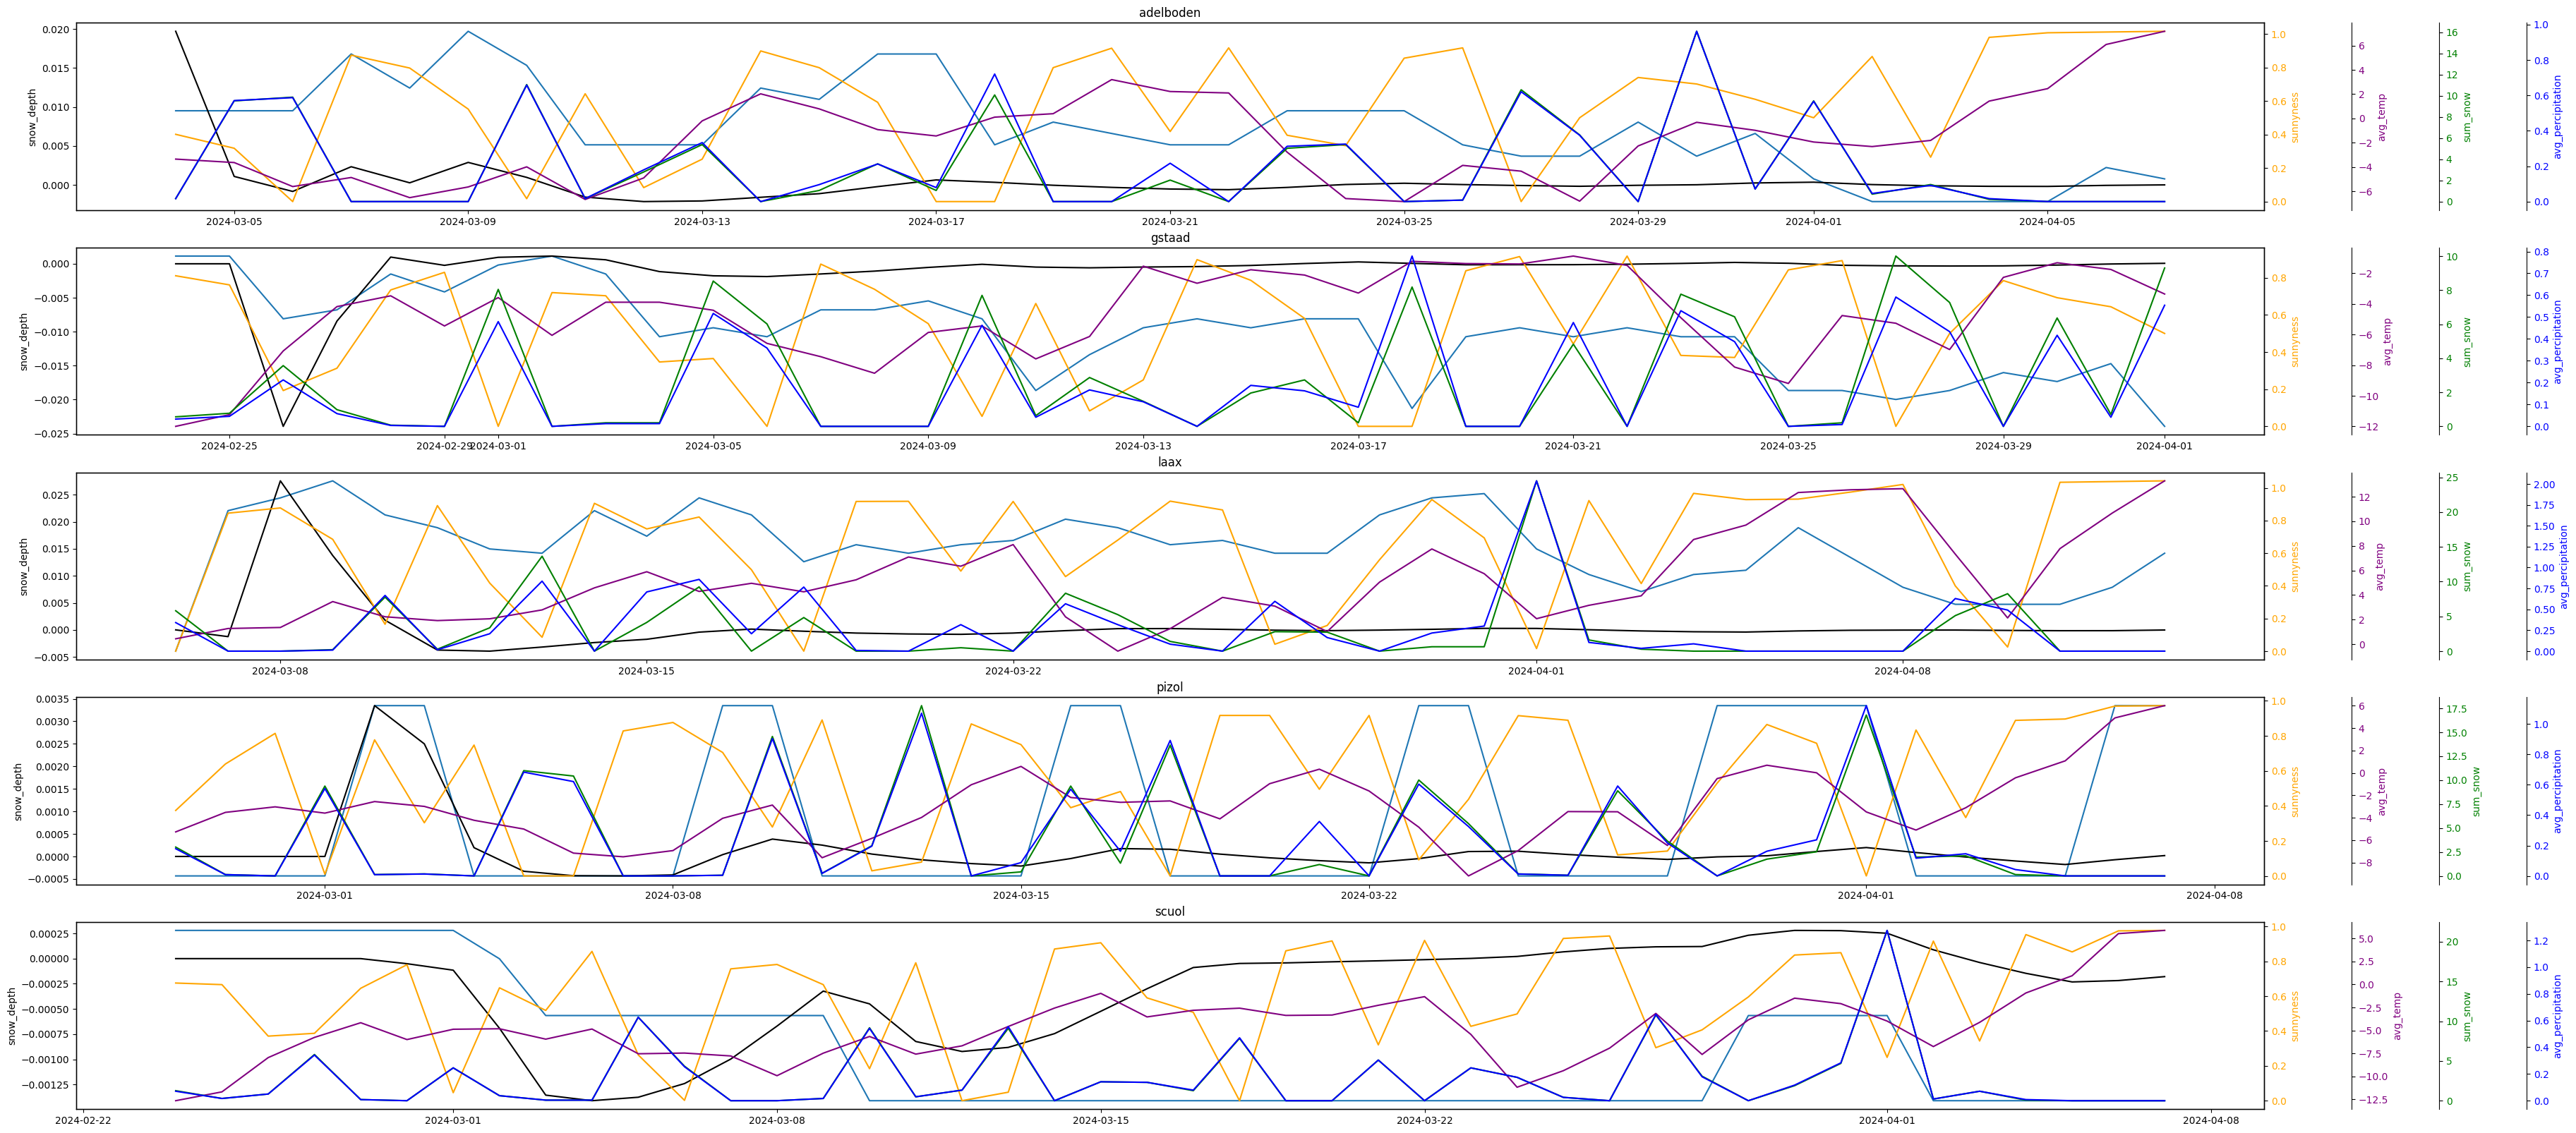

In [5]:
# Visual representation of used the dataset
fig = plt.figure(figsize=(40, 20))

for index, (resort, group) in enumerate(groups):
    axis = fig.add_subplot(
        len(groups),1,index+1,
        yticks=[],
        title=resort
    )
    axis.plot(group.index, group["max_price"])
    for index, (col, color) in enumerate([
        ('price_surge', 'black'),
        ('sunnyness', 'orange'),
        ('avg_temp', 'purple'),
        ('sum_snow', 'g'),
        ('avg_percipitation', 'b')
    ]):
        ax = axis.twinx()
        ax.plot(group.index, group[col], color=color)
        if index > 0:
            ax.set_yticks([])
            sax = ax.secondary_yaxis(1.0 + 0.04 * (index - 1))
            sax.set_ylabel(col, color=color)
            sax.tick_params(axis='y', labelcolor=color)
        else:
            ax.yaxis.set_ticks_position("left")
            ax.yaxis.set_label_position("left")
            ax.set_ylabel('snow_depth', color=color)
            ax.tick_params(axis='y', labelcolor=color)

/tmp/ipykernel_51972/1429476565.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


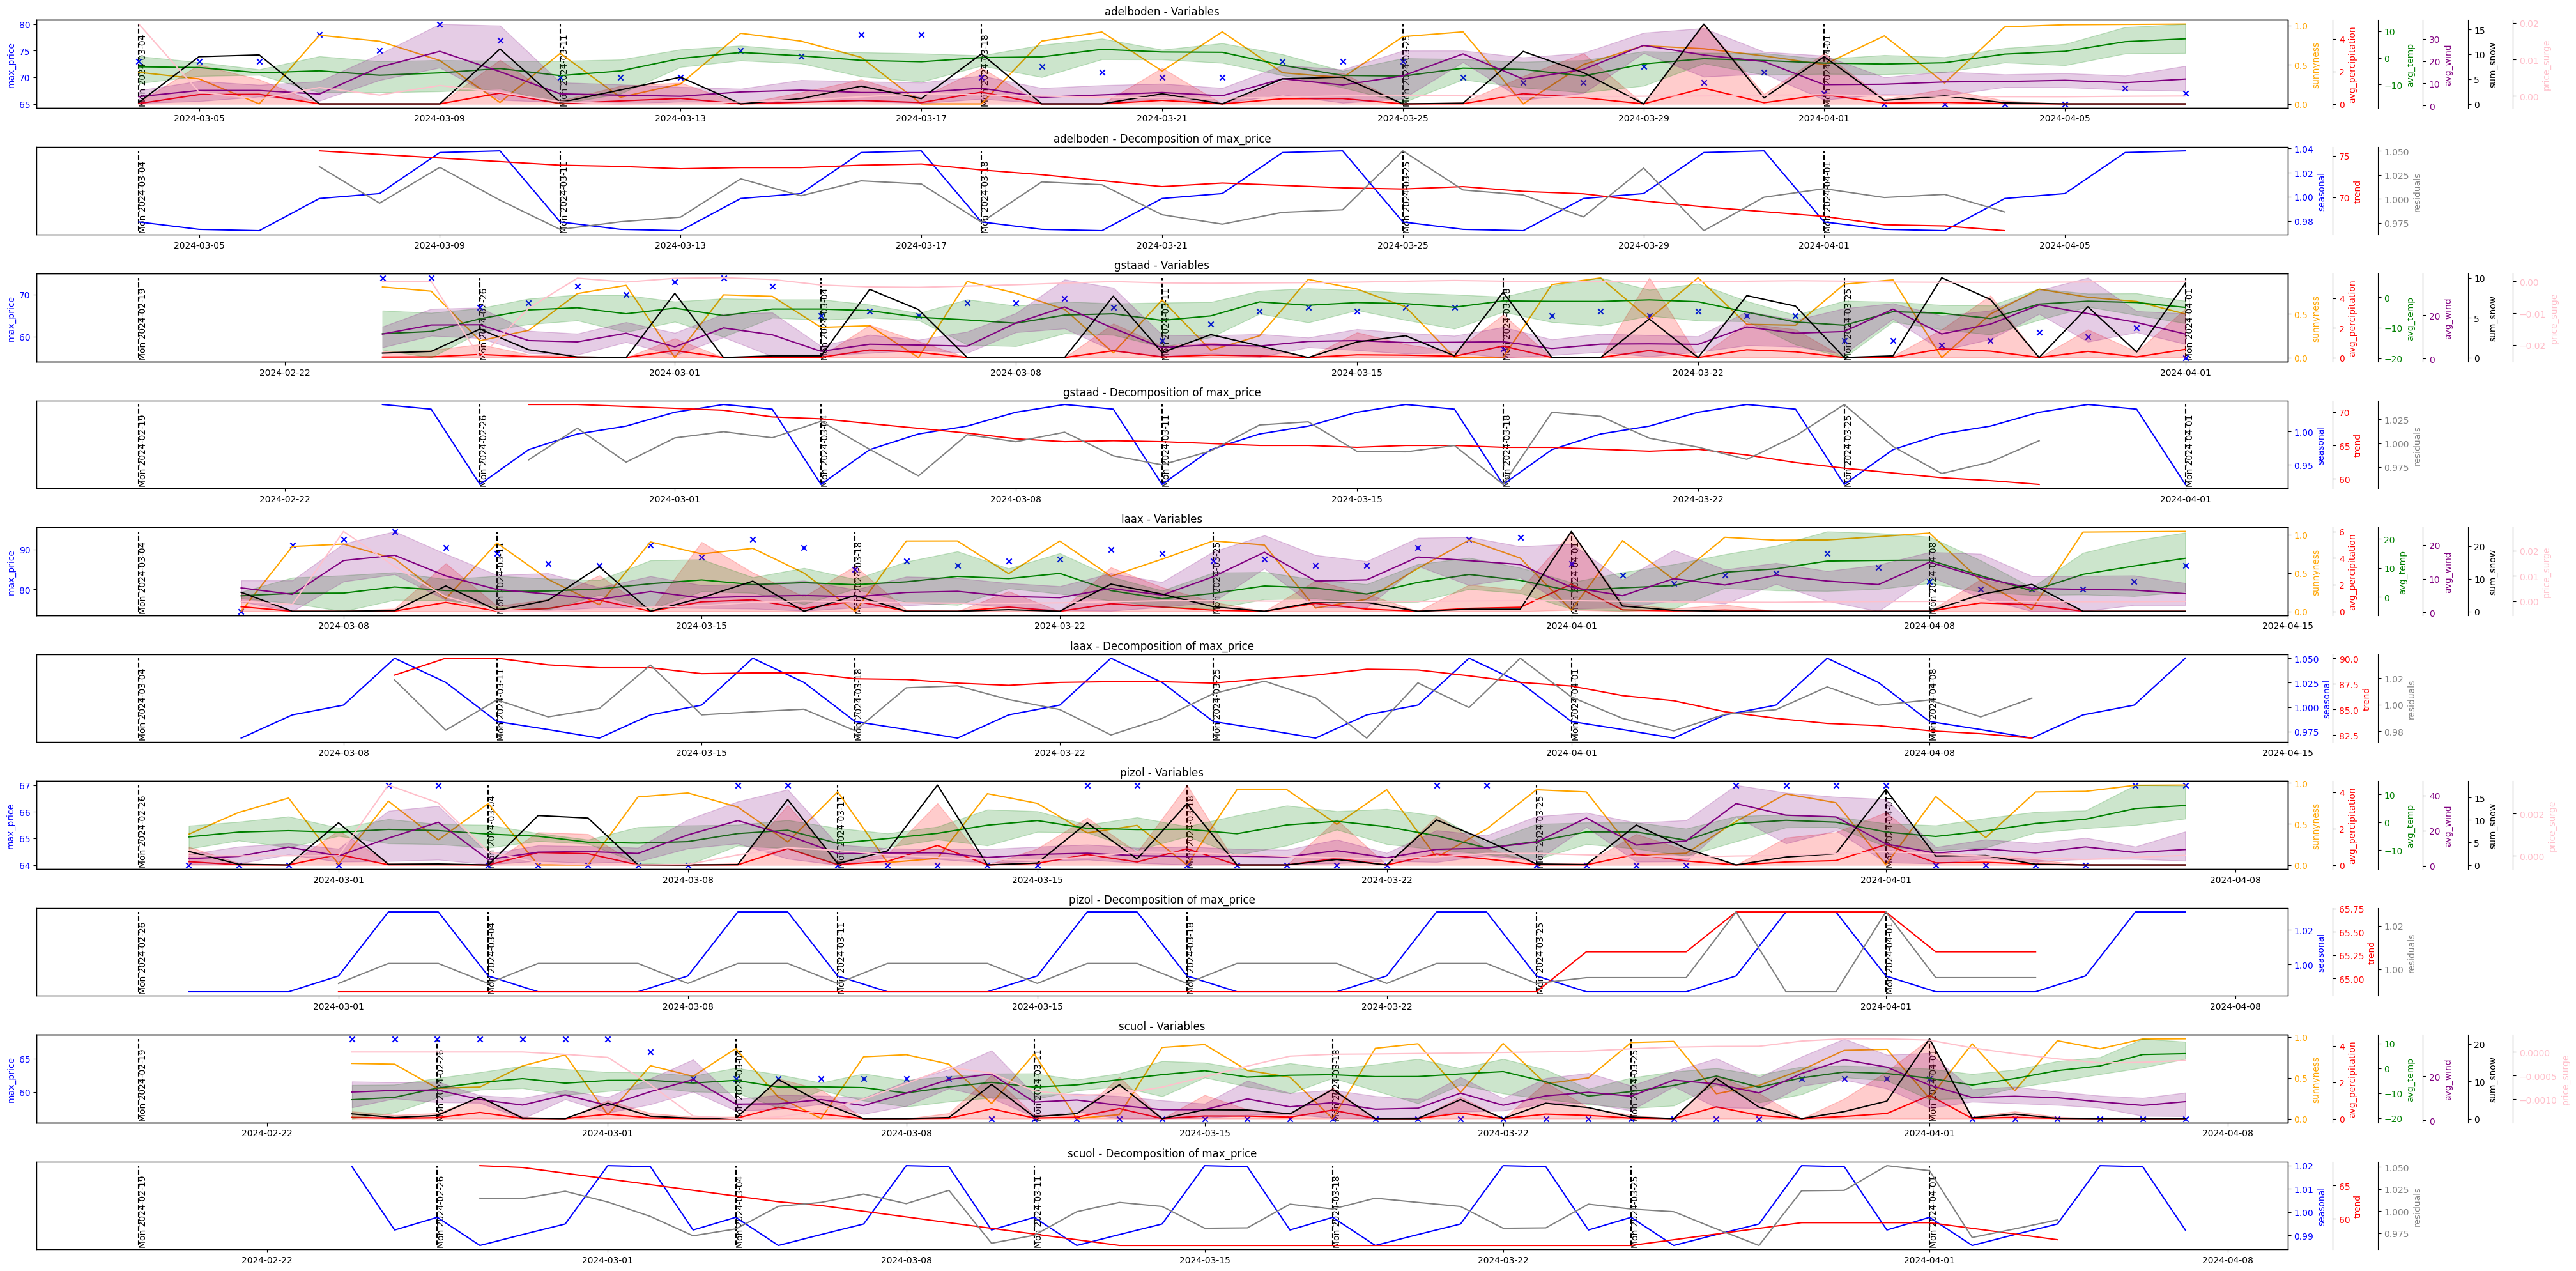

In [6]:
fig = plt.figure(figsize=(40, 20))        
for index, (resort, df) in enumerate(groups):
    axis = fig.add_subplot(
        2*len(groups.groups),1,2*index+1,
        yticks=[],
        title=f"{resort} - Variables"
    )
    add_axis_mondays(axis, df)

    for indx, (col, color, pltarea) in enumerate([
        ('max_price', 'blue', []),
        ('sunnyness', 'orange', []),
        ('avg_percipitation', 'red', ["max_percipitation", "min_percipitation"]),
        ('avg_temp', 'green', ["max_temp", "min_temp"]),
        ('avg_wind', 'purple', ["max_wind", "min_wind"]),
        ('sum_snow', 'black', []),
        ('price_surge', 'pink', []),
    ]):
        ax = axis.twinx()
        if indx > 0:
            ax.plot(df.index, df[col], color=color)
            if len(pltarea):
                ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
            ax.set_yticks([])
            sax = ax.secondary_yaxis(1.0 + 0.02 * (indx - 1))
            sax.set_ylabel(col, color=color)
            sax.tick_params(axis='y', labelcolor=color)
        else:
            ax.scatter(df.index, df[col], color=color, marker='x')
            ax.yaxis.set_ticks_position("left")
            ax.yaxis.set_label_position("left")
            ax.set_ylabel(col, color=color)
            ax.tick_params(axis='y', labelcolor=color)


    decomp_m = seasonal_decompose(np.array(df['max_price']), period = 7, model = 'multiplicative')
    df['seasonal'] = decomp_m.seasonal
    df['trend'] = decomp_m.trend
    df['residuals'] = decomp_m.resid
    axis_decomp = fig.add_subplot(
        2*len(groups.groups),1,2*index+2,
        yticks=[],
        title=f"{resort} - Decomposition of max_price"
    )
    add_axis_mondays(axis_decomp, df)
    for indx, (col, color, pltarea) in enumerate([
        ('seasonal', 'blue', []),
        ('trend', 'red', []),       
        ('residuals', 'grey', [])
    ]):
        ax = axis_decomp.twinx()
        ax.plot(df.index, df[col], color=color)
        if len(pltarea):
            ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
        ax.set_yticks([])
        sax = ax.secondary_yaxis(1.0 + 0.02 * (indx))
        sax.set_ylabel(col, color=color)
        sax.tick_params(axis='y', labelcolor=color)

    

fig.tight_layout()
fig.show()

/usr/local/python/3.12.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 6.273590746409


/usr/local/python/3.12.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 6.363878387041911


/usr/local/python/3.12.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 5.638404460226251


/usr/local/python/3.12.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE: 1.4533145206761253


/usr/local/python/3.12.3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tmp/ipykernel_51972/442351239.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


RMSE: 4.652581987614845


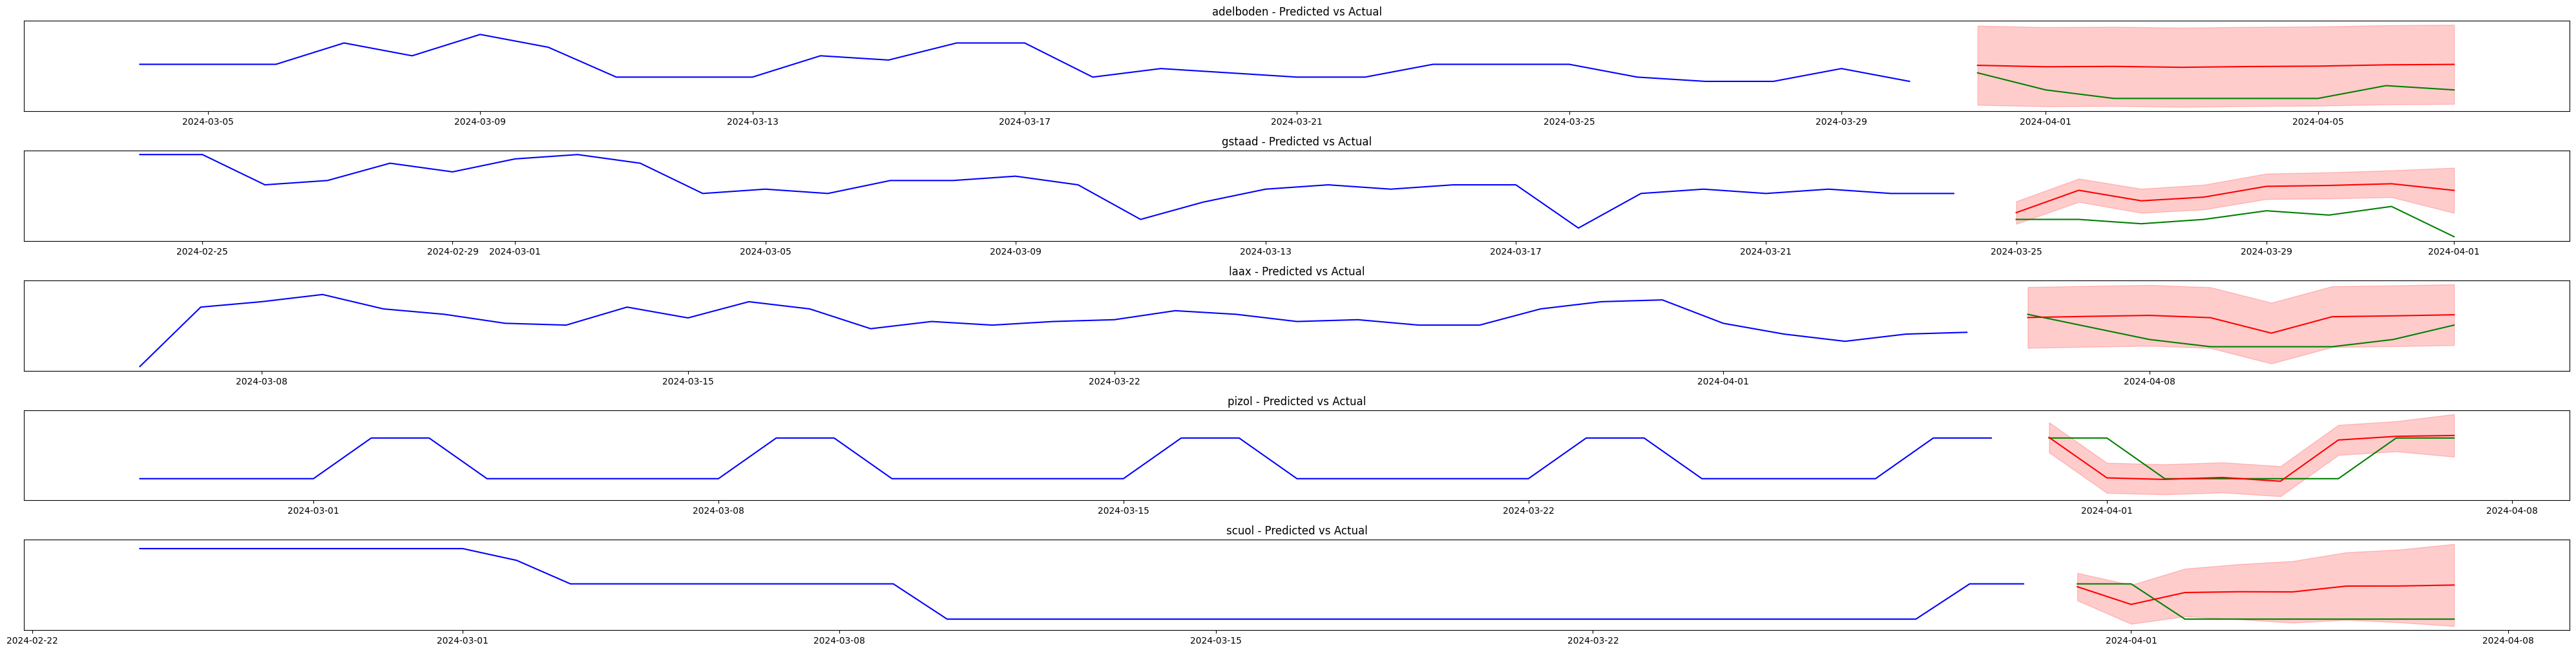

In [7]:
fig = plt.figure(figsize=(40, 20)) 
for index, (resort, df) in enumerate(groups):
    ds_prep = df[["max_price", "sunnyness", "avg_temp", "sum_snow", "avg_percipitation", "price_surge"]]
    cutoff = ds_prep.index[-1] - datetime.timedelta(days=7) #"2024-03-22"
    X_train, X_test = ds_prep.loc[ds_prep.index < cutoff].copy(), ds_prep.loc[ds_prep.index >= cutoff].copy()
    Y_train, Y_test = X_train["max_price"], X_test["max_price"]

    X_train.drop(columns=["max_price"], inplace=True)
    X_test.drop(columns=["max_price"], inplace=True)

    model_0 = auto_arima(y = Y_train, X = X_train, start_p = 0, d = None, start_q = 0, 
                        max_p = 4, max_d = 2, max_q = 4, 
                        start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, 
                        max_Q = 3, max_order = 8,
                        start_params = None,
                        stepwise = True, maxiter = 30,
                        m = 7, seasonal = True, stationary = False,
                        information_criterion = 'aic', 
                        alpha = 0.05, test = 'kpss', seasonal_test = 'ocsb',
                        with_intercept = 'auto', method = 'lbfgs',
                        suppress_warnings = True, error_action = 'trace', trace = False)


    model_p_0 = model_0.predict(n_periods = len(Y_test), X = X_test, return_conf_int = True)
    #print('Predicted:', list(zip(model_p_0[0], Y_test)))
    print('RMSE:', mean_squared_error(Y_test, model_p_0[0], squared = False))

    axis = fig.add_subplot(
        2*len(groups.groups),1,index+1,
        yticks=[],
        title=f"{resort} - Predicted vs Actual"
    )
    axis.plot(X_train.index, Y_train, color='blue')
    axis.plot(X_test.index, Y_test, color='green')
    axis.plot(X_test.index, model_p_0[0], color='red')
    axis.fill_between(X_test.index, model_p_0[1][:,0], model_p_0[1][:,1], color='red', alpha=.2)

fig.tight_layout()
fig.show()

/tmp/ipykernel_51972/1670043942.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


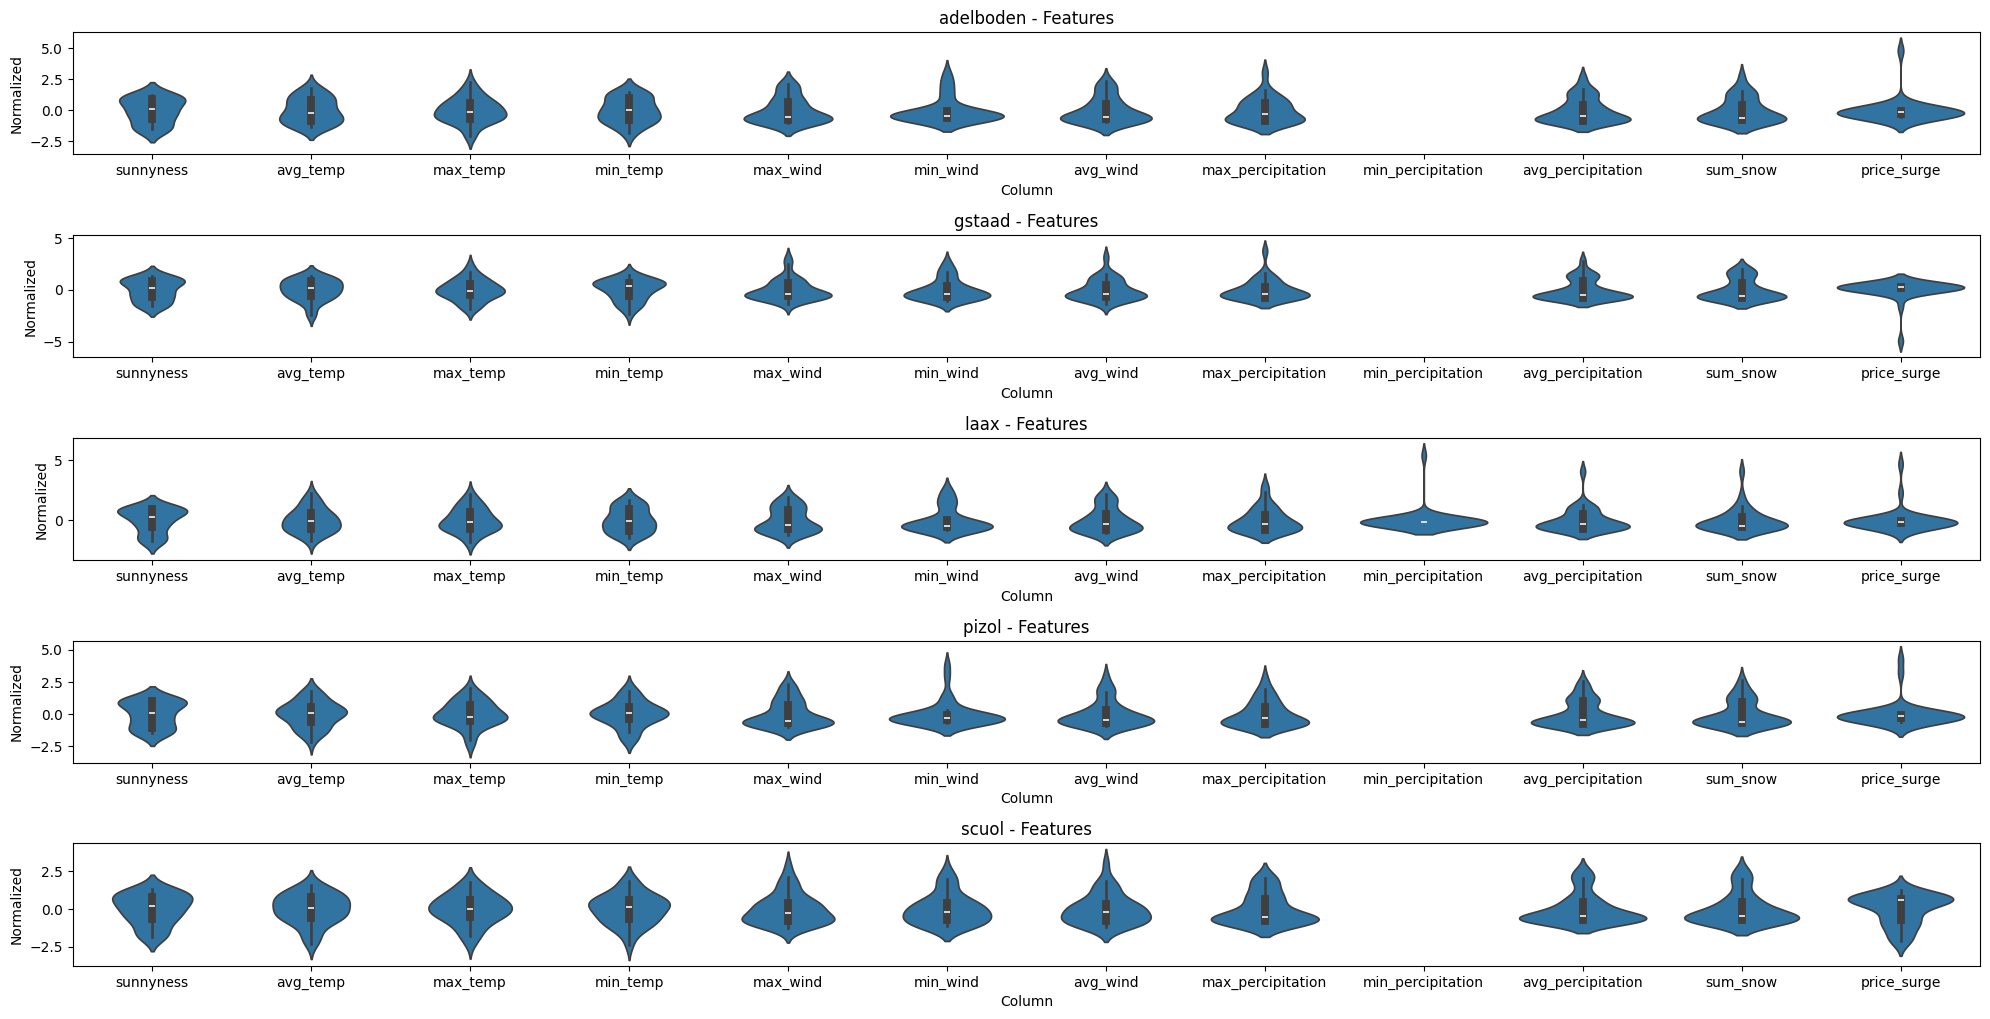

In [8]:
# Violin plot of the features
# Analyse the distribution of the features - are they normally distributed?
# see more details: https://seaborn.pydata.org/generated/seaborn.violinplot.html
fig = plt.figure(figsize=(20, 20)) 
for index, (resort, df) in enumerate(groups):
    ds_prep = df[["max_price", "sunnyness", "avg_temp", "max_temp", "min_temp", "max_wind", "min_wind", "avg_wind", "max_percipitation", "min_percipitation", "avg_percipitation", "sum_snow", "avg_percipitation", "price_surge"]]
    cutoff = ds_prep.index[-1] - datetime.timedelta(days=7) #"2024-03-22"
    X_train, X_test = ds_prep.loc[ds_prep.index < cutoff].copy(), ds_prep.loc[ds_prep.index >= cutoff].copy()
    Y_train, Y_test = X_train["max_price"], X_test["max_price"]
    X_train.drop(columns=["max_price"], inplace=True)
    X_test.drop(columns=["max_price"], inplace=True)

    train_mean = X_train.mean()
    train_std = X_train.std()
    df_std = (X_train - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    axis = fig.add_subplot(
        2*len(groups.groups),1,index+1,
        title=f"{resort} - Features"
    )
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std, ax=axis)

fig.tight_layout()
fig.show()


In [87]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, test_df, val_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def plot(self, model, plot_col, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)
  
  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


MAX_EPOCHS = 500
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      callbacks=[early_stopping])
  return history


for index, (resort, df) in list(enumerate(groups))[1:2]:
    #ds_prep = df[["max_price", "sunnyness", "avg_temp", "max_temp", "min_temp", "max_wind", "min_wind", "avg_wind", "max_percipitation", "min_percipitation", "avg_percipitation", "sum_snow", "avg_percipitation", "price_surge", "weekday"]]
    ds_prep = df[["max_price", "sunnyness", "avg_temp", "max_wind", "avg_wind", "max_percipitation", "avg_percipitation", "sum_snow", "price_surge", "weekday"]]
    #cutoff = ds_prep.index[-1] - datetime.timedelta(days=7) #"2024-03-22"
    #train_df, test_df = ds_prep.loc[ds_prep.index < cutoff].copy(), ds_prep.loc[ds_prep.index >= cutoff].copy()
    train_df, test_df, val_df = ds_prep[0:math.floor(len(ds_prep)*0.6)], ds_prep[math.floor(len(ds_prep)*0.6):math.floor(len(ds_prep)*0.8)], ds_prep[math.floor(len(ds_prep)*0.8):]

    column_indices = {name: i for i, name in enumerate(ds_prep.columns)}
    wide_window = WindowGenerator(
      input_width=6, label_width=6, shift=1,
      label_columns=['max_price'],
      train_df=train_df, test_df=test_df, val_df=val_df
    )

    single_step_window = WindowGenerator(
      input_width=1, label_width=1, shift=1,
      label_columns=['max_price'],
      train_df=train_df, test_df=test_df, val_df=val_df
    )
    baseline = Baseline(label_index=column_indices['max_price'])
    baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    val_performance = {}
    performance = {}
    #val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
    performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)
    #print(performance)

    # linear = tf.keras.Sequential([
    #   tf.keras.layers.Dense(units=1)
    # ])
    # compile_and_fit(linear, single_step_window)
    # performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

    # dense = tf.keras.Sequential([
    #   tf.keras.layers.Dense(units=64, activation='relu'),
    #   tf.keras.layers.Dense(units=64, activation='relu'),
    #   tf.keras.layers.Dense(units=1)
    # ])
    # compile_and_fit(dense, single_step_window)
    # performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

    # conv_window = WindowGenerator(
    #   input_width=3, label_width=1, shift=1,
    #   label_columns=['max_price'],
    #   train_df=train_df, test_df=test_df, val_df=val_df
    # )
    # multi_step_dense = tf.keras.Sequential([
    #   # Shape: (time, features) => (time*features)
    #   tf.keras.layers.Flatten(),
    #   tf.keras.layers.Dense(units=32, activation='relu'),
    #   tf.keras.layers.Dense(units=32, activation='relu'),
    #   tf.keras.layers.Dense(units=1),
    #   # Add back the time dimension.
    #   # Shape: (outputs) => (1, outputs)
    #   tf.keras.layers.Reshape([1, -1]),
    # ])
    # compile_and_fit(multi_step_dense, conv_window)
    # performance['MSD'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)


    # conv_model = tf.keras.Sequential([
    #   tf.keras.layers.Conv1D(filters=32,
    #                         kernel_size=(3,),
    #                         activation='relu'),
    #   tf.keras.layers.Dense(units=32, activation='relu'),
    #   tf.keras.layers.Dense(units=1),
    # ])
    # compile_and_fit(conv_model, conv_window,patience=10)
    # performance['CONF'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

    CONV_WIDTH = 7
    OUT_STEPS = 8
    multi_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=OUT_STEPS,
        shift=1,
        label_columns=['max_price'],
        train_df=train_df, test_df=test_df, val_df=val_df
    )
    print(multi_window)
    break

    multi_lstm_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, lstm_units].
      # Adding more `lstm_units` just overfits more quickly.
      tf.keras.layers.LSTM(64, return_sequences=False),
      # Shape => [batch, out_steps*features].
      tf.keras.layers.Dense(OUT_STEPS*len(single_step_window.column_indices)),
      # Shape => [batch, out_steps, features].
      tf.keras.layers.Reshape([OUT_STEPS, len(single_step_window.column_indices)])
    ])

    compile_and_fit(multi_lstm_model, multi_window, patience=50)
    val_performance['MLSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
    performance['MLSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)


    #print('Input shape:', wide_window.example[0].shape)
    #print('Output shape:', baseline(wide_window.example[0]).shape)
    #wide_window.plot(baseline, plot_col='max_price')
    multi_window.plot(multi_lstm_model, plot_col='max_price', max_subplots=10)
    #print(len(train_df))
    #print(w1)
    #w1.plot(*w1.split_window(), plot_col="max_price", max_subplots=5)
    #print(w1.train.take(1))

    print(performance)
    print(val_performance)

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [0 1 2 3 4 5 6 7]
Label column name(s): ['max_price']


In [564]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               data,
               label_columns=None):
    # Store the raw data.
    self.data = data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(data[0][0].columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def plot(self, model, plot_col, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, datas):
    ds = None
    for data in datas:
      data = np.array(data, dtype=np.float32)
      d = tf.keras.utils.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
      if ds:
        ds = ds.concatenate(d)
      else:
        ds = d

    ds = ds.map(self.split_window)

    return ds

  @property
  def example(self):
    result = getattr(self, '_example', None)
    if result is None:
      result = next(iter(self.train))
      self._example = result
    return result
  
  @property
  def val(self):
    val = [d[1] for d in self.data]
    return self.make_dataset(val)

  @property
  def train(self):
    train = [d[0] for d in self.data]
    return self.make_dataset(train)


MAX_EPOCHS = 3000
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=10,
  )

  model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
  )

  history = model.fit(
    window.train,
    epochs=MAX_EPOCHS,
    validation_data=window.val,
    callbacks=[early_stopping]
  )
  return history

data = []
for index, (resort, df) in list(enumerate(groups)):
    ds_prep = df[["sunnyness", "avg_percipitation", "sum_snow", "weekday", "weekend", "max_price"]]
    #ds_prep['max_price'] = normalize(df["max_price"].to_numpy()).squeeze()

    #max_price_mean = ds_prep['max_price'].mean()
    #ds_prep['max_price'] = ds_prep['max_price'].apply(lambda x: 1 if x > max_price_mean else 0)
    train_df, val_df = ds_prep[0:math.floor(len(ds_prep)*0.7)], ds_prep[math.floor(len(ds_prep)*0.7):]
    data.append((train_df, val_df))

column_indices = {name: i for i, name in enumerate(data[0][0].columns)}

CONV_WIDTH = 4
OUT_STEPS = 4
multi_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=OUT_STEPS,
    shift=1,
    label_columns=['max_price'],
    data=data
)

multi_lstm_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="causal", activation="relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(OUT_STEPS*len(multi_window.column_indices)),
  tf.keras.layers.Reshape([OUT_STEPS, len(multi_window.column_indices)])
])

history = compile_and_fit(multi_lstm_model, multi_window, patience=5)
#multi_window.plot(multi_lstm_model, plot_col='max_price', max_subplots=10)


Epoch 1/3000


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 222ms/step - loss: 5331.3867 - mean_absolute_error: 72.4638 - val_loss: 4490.9775 - val_mean_absolute_error: 66.4065
Epoch 2/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 5327.9883 - mean_absolute_error: 72.4404 - val_loss: 4487.9263 - val_mean_absolute_error: 66.3836
Epoch 3/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 5324.6050 - mean_absolute_error: 72.4171 - val_loss: 4484.8662 - val_mean_absolute_error: 66.3606
Epoch 4/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 5321.2065 - mean_absolute_error: 72.3936 - val_loss: 4481.7773 - val_mean_absolute_error: 66.3373
Epoch 5/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 5317.7710 - mean_absolute_error: 72.3699 - val_loss: 4478.6411 - val_mean_absolute_error: 66.3137
Epoch 6/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 5314.2783 - mean_absolute_error: 72.3458 - val_loss: 4475.4375 - val_mean_absolute_error: 66.2896
Epoch 7/3000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 5310.7051 

In [565]:
multi_lstm_model.save('multi_lstm_model.keras')

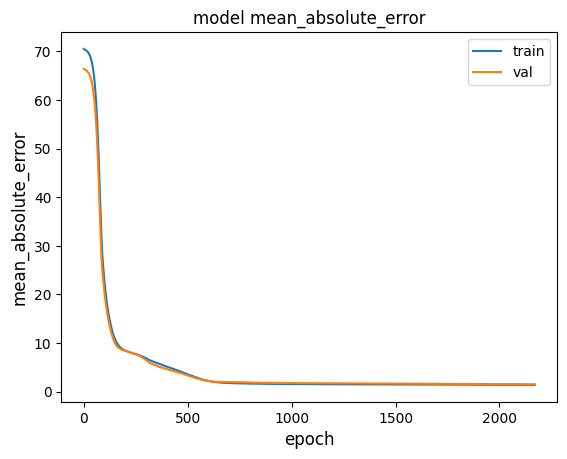

In [571]:
metric = "mean_absolute_error"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

/tmp/ipykernel_51972/2204693910.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


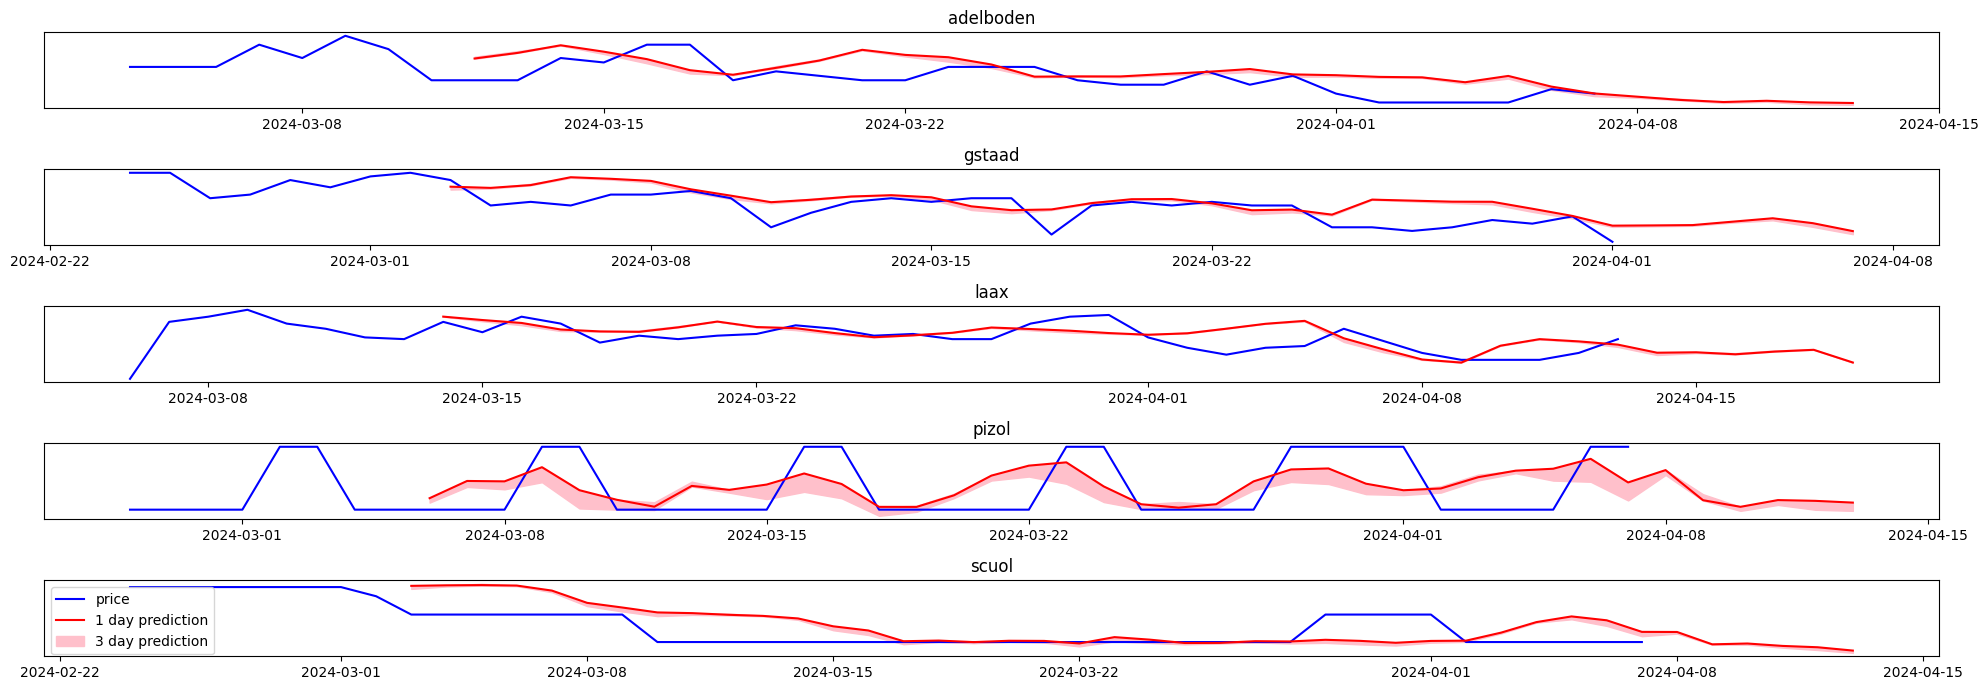

In [601]:
def plot(model, data, ax=None):
    pp = {}
    for index, (date, df) in list(enumerate(data.iterrows())):
        if index + 2 < len(data):
            inputs = np.array(data.iloc[index:index+CONV_WIDTH], dtype=np.float32)
            inputs = inputs[np.newaxis, :]
            predictions = model(inputs)
            preds = [p.numpy()[-1] for p in predictions[0]]

            p_date = date + datetime.timedelta(days=CONV_WIDTH+OUT_STEPS)
            if p_date not in pp:
                pp[p_date] = {"0": preds[0], "max": preds[0], "min": preds[0]}

            pred_max = max(preds[0:3])
            pred_min = min(preds[0:3])

            if pred_max > pp[p_date]["max"]:
                pp[p_date]["max"] = pred_max

            if pred_min < pp[p_date]["min"]:
                pp[p_date]["min"] = pred_min
    
    d = pd.DataFrame.from_dict(pp, orient='index')

    ax.plot(data.index, data["max_price"], color="blue", label="price")
    ax.plot(d.index, d["0"], color="red", label="1 day prediction")
    ax.fill_between(d.index, d["min"], d["max"], color="pink", label="3 day prediction")

fig = plt.figure(figsize=(20, 7))

for index, (resort, df) in list(enumerate(groups)):
    ds_prep = df[["sunnyness", "avg_percipitation", "sum_snow", "weekday", "weekend", "max_price"]]
    axis = fig.add_subplot(
        5,1,index+1,
        yticks=[],
        title=resort
    )
    plot(model=multi_lstm_model, data=ds_prep, ax=axis)

plt.legend(loc="upper left")
fig.tight_layout()
fig.show()

In [604]:
import os
import platform
from platform import python_version

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-28-generic
Datetime: 2024-05-01 09:35:23
Python Version: 3.12.3
-----------------------------------
